In [1]:
!pip install torchmetrics
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 9.7 MB/s eta 0:00:00


In [2]:
#import

import zipfile
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
from thop import profile, clever_format

import torch.nn as nn
import torch.optim as optim

from torchmetrics import JaccardIndex
import torch.nn.functional as F
import random

from tqdm import tqdm

In [3]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip

--2025-01-05 10:06:43--  https://zenodo.org/record/5706578/files/Train.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5706578/files/Train.zip [following]
--2025-01-05 10:06:43--  https://zenodo.org/records/5706578/files/Train.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip’

Train.zip           100%[===================>]   3.75G  12.6MB/s    in 5m 11s  

2025-01-05 10:11:54 (12.3 MB/s) - ‘Train.zip’ saved [4021669263/4021669263]

--2025-01-05 10:11:54--  https://zenodo.org/record/5706578/files/Val.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request 

In [4]:
# Define file paths
train_zip = "Train.zip"
val_zip = "Val.zip"

# Extract Train.zip
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("Train")

# Extract Val.zip
with zipfile.ZipFile(val_zip, 'r') as zip_ref:
    zip_ref.extractall("Val")

# Verify the extracted folders
print("Train Directory Contents:", os.listdir("Train"))
print("Val Directory Contents:", os.listdir("Val"))

Train Directory Contents: ['Train']
Val Directory Contents: ['Val']


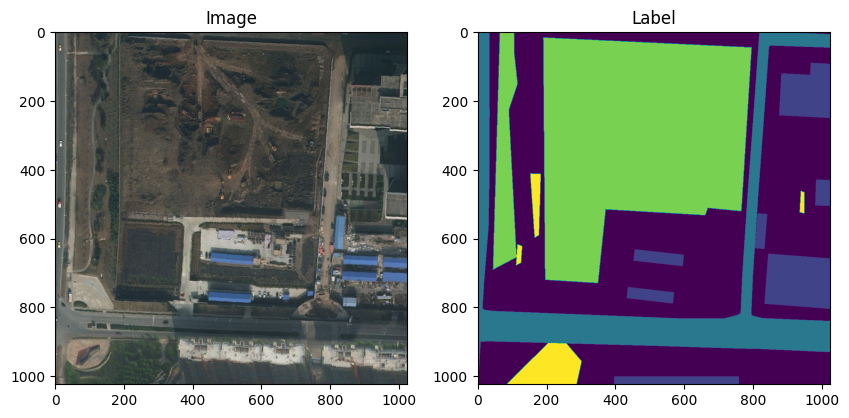

In [5]:
# Load and visualize an image and its corresponding label
image_path = "Train/Train/Urban/images_png/1366.png"
label_path = "Train/Train/Urban/masks_png/1366.png"

image = Image.open(image_path)
label = Image.open(label_path)

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Label")
plt.imshow(label)
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


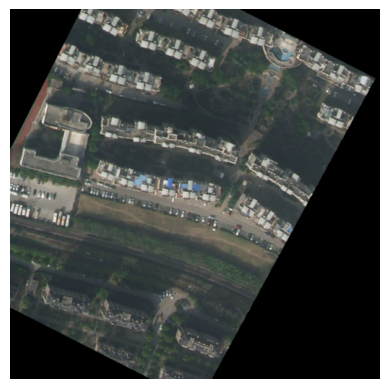

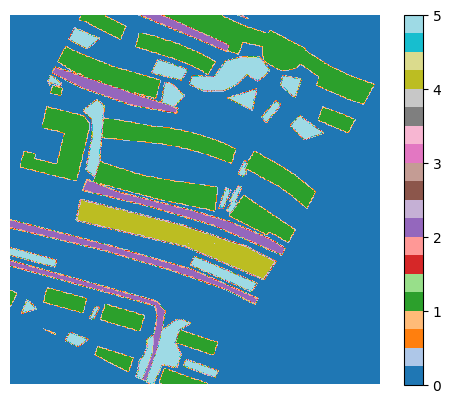

In [6]:
#TASK 3.b

COLOR_MAP = {
    'Background': 0.00392157,
    'Building': 0.00784314,
    'Road': 0.01176471,
    'Water': 0.01568628,
    'Barren': 0.01960784,
    'Forest': 0.02352941,
    'Agricultural': 0.02745098
}

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)

# Tolerance-based color to label conversion
def color_to_one_hot(mask, label_map, tolerance=0.001, num_classes=7):
    mask = np.asarray(mask, dtype=np.float32)
    if len(mask.shape) == 2:  # Ensure channel dimension exists
        mask = np.expand_dims(mask, axis=0)  # Convert [H, W] to [1, H, W]

    one_hot_mask = np.zeros((num_classes, mask.shape[1], mask.shape[2]), dtype=np.float32)

    for class_name, class_index in label_map.items():
        color_value = COLOR_MAP[class_name]
        # Match pixels with the grayscale value within the tolerance
        matches = np.abs(mask - color_value) < tolerance
        one_hot_mask[class_index, np.squeeze(matches, axis=0)] = 1.0

    return torch.from_numpy(one_hot_mask)


# Define a function to denormalize the image
def denormalize(tensor, mean, std):
    """ Denormalize the tensor back to the [0, 1] range for visualization. """
    for i in range(len(mean)):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor

def show_image(image_tensor):
    """ Display a transformed image using matplotlib. """
    image_tensor = denormalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Denormalize the image
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HxWxC format
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

def show_mask(mask_tensor, num_classes=7):
    """ Display the mask using matplotlib. """
    # Convert the one-hot mask to the label mask (indices of the highest value per pixel)
    mask = mask_tensor.squeeze().cpu().numpy()  # Remove the batch dimension and convert to numpy
    label_mask = np.argmax(mask, axis=0)  # Get the class index with the highest value for each pixel

    plt.imshow(label_mask, cmap='tab20')  # Use a colormap suitable for categorical data
    plt.colorbar()  # Optionally add a color bar
    plt.axis('off')  # Hide axes
    plt.show()


class LoveDADataset(Dataset):
    def __init__(self, root_dir, split='train', transform_image=None, transform_label=None, subdir="Rural", aug1=False, aug2=False):
        self.root_dir = root_dir
        self.split = split
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.aug1 = aug1
        self.aug2 = aug2
        self.image_paths = []
        self.label_paths = []

        image_dir = os.path.join(root_dir, split, subdir, 'images_png')
        label_dir = os.path.join(root_dir, split, subdir, 'masks_png')

        for f in os.listdir(image_dir):
            if f.endswith('.png'):
                self.image_paths.append(os.path.join(image_dir, f))
                self.label_paths.append(os.path.join(label_dir, f))

    def __len__(self):
        original_length = len(self.image_paths)
        if self.aug1 and self.aug2:
            return original_length * 7
        elif self.aug1 or self.aug2:
            return original_length * 4
        else:
            return original_length


    def __getitem__(self, idx):
        original_length = len(self.image_paths)

        # Calcola l'indice originale nel dataset
        idx = idx % original_length

        # Carica l'immagine e la maschera
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = Image.open(self.label_paths[idx]).convert("L")

        image_np = np.array(image)
        label_np = np.array(label)

        # Seed per garantire coerenza tra immagine e maschera
        seed = np.random.randint(2147483647)

        # Applica augmentazione se abilitata
        if self.aug1:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            transform_aug1 = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30)
            ])
            image = Image.fromarray(image_np)
            image = transform_aug1(image)
            image_np = np.array(image)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            label = Image.fromarray(label_np)
            label = transform_aug1(label)
            label_np = np.array(label)

        if self.aug2:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            transform_aug2 = transforms.Compose([
                #sigma=(0.1, 5) indica un intervallo di valori tra 0.1 e 5, quindi la sfocatura potrebbe variare in base a come viene applicata.
                transforms.GaussianBlur(kernel_size=(5,9), sigma=( 0.1, 5)) #valori di dimensioni (5, 9), che significa che il filtro si estende su un'area di 5x9 pixel.
            ])
            image = Image.fromarray(image_np)
            image = transform_aug2(image)
            image_np = np.array(image)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            label = Image.fromarray(label_np)
            label = transform_aug2(label)
            label_np = np.array(label)

        # Trasformazioni opzionali per immagine e maschera
        if self.transform_image:
            transform_image_alb = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            image = Image.fromarray(image_np)
            image = transform_image_alb(image)

        if self.transform_label:
            transform_label_alb = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()
            ])
            label = Image.fromarray(label_np)
            label = transform_label_alb(label).squeeze(0)
            label = color_to_one_hot(label, LABEL_MAP)

        return image, label

# Define transformations without augmentations
transform_image = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

transform_label = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Set augmentation flags
AUG1 = True
AUG2 = False

BATCH_SIZE = 16 #or 32, or 64 ...
NUM_WORKERS = 8 # Number of cpu cores
PIN_MEMORY = True
PERSISTENT_WORKERS = False # Set true if you have persistent workers issues
# Create dataset and dataloader with augmentations
train_dataset = LoveDADataset(root_dir='Train/', split='Train', transform_image=transform_image, transform_label=transform_label, subdir='Urban', aug1=AUG1, aug2=AUG2)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)


val_dataset = LoveDADataset(root_dir='Val/', split='Val', transform_image=transform_image, transform_label=transform_label, subdir='Rural')
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Visualize the first batch of images
for i, (image, label) in enumerate(train_loader):
    if i == 0:  # Show only the first batch
        show_image(image[0])  # Access the first image of the batch
        show_mask(label[0])
        break


# # Definisci una dimensione più piccola per il subset (ad esempio 10% del dataset)
# subset_size = 100  # Usa solo i primi 100 campioni per il test

# # Usa torch.utils.data.Subset per ottenere un subset casuale dei dati
# subset_indices = torch.randperm(len(train_loader.dataset)).tolist()[:subset_size]
# train_subset = torch.utils.data.Subset(train_loader.dataset, subset_indices)

# # Crea un DataLoader per il subset
# #DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)
# train_subset_loader = DataLoader(train_subset, batch_size=2, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)
# for i, (image, label) in enumerate(train_subset_loader):
#     if i == 0:  # Show only the first batch
#         show_image(image[0])  # Access the first image of the batch
#         show_mask(label[0])
#         break


Visualizing image 1


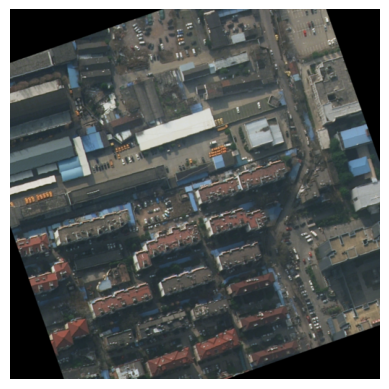

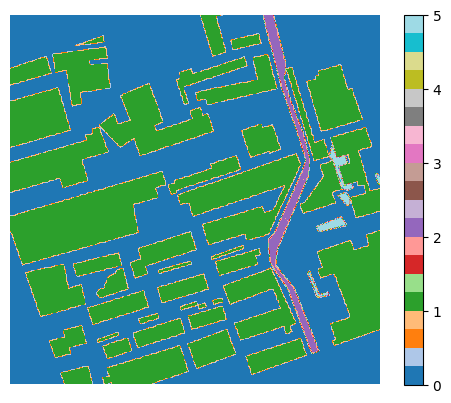

In [7]:
# Funzione per visualizzare immagini con augmentations applicate
def visualize_augmented_images(dataloader, num_images=1):
    """
    Visualizza immagini con augmentations applicate.
    Args:
        dataloader: Il DataLoader dal quale prelevare le immagini.
        num_images: Numero di immagini da visualizzare.
    """
    count = 0
    for images, labels in dataloader:
        for i in range(images.size(0)):
            if count >= num_images:
                return  # Mostra solo il numero richiesto di immagini
            print(f"Visualizing image {count + 1}")
            show_image(images[i])  # Visualizza l'immagine
            show_mask(labels[i])  # Visualizza la maschera
            count += 1

# Visualizza immagini con augmentations dal train_loader
visualize_augmented_images(train_loader, num_images=1)

In [8]:
!git clone https://github.com/XuJiacong/PIDNet.git
%cd PIDNet

Cloning into 'PIDNet'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 386 (delta 131), reused 125 (delta 125), pack-reused 193 (from 1)
Receiving objects: 100% (386/386), 212.80 MiB | 6.72 MiB/s, done.
Resolving deltas: 100% (184/184), done.
/content/PIDNet


In [9]:
from models.pidnet import get_pred_model

# Initialize PIDNet-S model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_pred_model(name='pidnet_s', num_classes=7).to(device)

In [10]:
%cd ..

/content


In [12]:
num_classes=7

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define mIoU metric
jaccard = JaccardIndex(task="multiclass", num_classes=7).to('cuda')  # intersection over union. Directly measures the overlap between predicted segmentation and ground truth.


# Training loop
num_epochs = 20 #20
best_miou = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") # train_loader
    for images, masks in train_progress_bar:
        images, masks = images.to(device), masks.to(device)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        outputs = model(images)

        # Upsample model outputs to match the target resolution (512x512)
        outputs_resized = F.interpolate(outputs, size=(masks.shape[2], masks.shape[3]), mode='bilinear', align_corners=False)

        # Ensure masks are in the right shape and type (long)
        masks = masks.squeeze(1)  # Remove extra channel dimension and convert to long

        # Calculate loss
        loss = criterion(outputs_resized, masks)  # Use CrossEntropyLoss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm progress bar with real-time loss using set_postfix
        train_progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(train_loader) #len(train_subset_loader) #len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {avg_loss:.4f}")

    # Clear GPU memory
    torch.cuda.empty_cache()

    # Validation loop
    model.eval()
    val_miou = 0.0
    val_class_iou = torch.zeros(len(LABEL_MAP)).to('cuda')  # Store IoU per class
    val_class_counts = torch.zeros(len(LABEL_MAP)).to('cuda')  # To track number of pixels for each class

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to('cuda'), masks.to('cuda')

            # Forward pass
            outputs = model(images)  # [batch_size, num_classes, 64, 64]
            preds = torch.argmax(outputs, dim=1)  # [batch_size, 64, 64]

            # Convert masks to class indices format if one-hot encoded
            if masks.ndim == 4:  # [batch_size, num_classes, height, width]
                masks = masks.argmax(dim=1)  # [batch_size, height, width]

            # Resize preds to match the size of the masks
            preds_resized = F.interpolate(preds.unsqueeze(1).float(), size=masks.shape[1:], mode='nearest').squeeze(1).long()

            # Calculate per-class IoU
            for c, class_name in LABEL_MAP.items():  # Iterate over LABEL_MAP classes
                true_class = (masks == class_name)
                pred_class = (preds_resized == class_name)

                intersection = torch.sum(true_class & pred_class).float()
                union = torch.sum(true_class | pred_class).float()

                if union != 0:
                    val_class_iou[class_name] += intersection / union
                val_class_counts[class_name] += 1

            # Calculate overall mIoU for this batch
            val_miou += jaccard(preds_resized, masks)

    # Average metrics
    val_miou /= len(val_loader)

    # Calculate average IoU for each class
    avg_class_iou = val_class_iou / val_class_counts

    # Print validation metrics at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation mIoU: {val_miou:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] - Per-Class IoU: {dict(zip(LABEL_MAP.keys(), avg_class_iou.tolist()))}")

    # Save the best model
    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(model.state_dict(), 'best_pidnet_model.pth')

print(f"Best Validation mIoU: {best_miou:.4f}")


Epoch 1/20: 100%|██████████| 289/289 [08:14<00:00,  1.71s/batch, loss=0.9195]

Epoch [1/20] Loss: 0.9354


Epoch [1/20] - Validation mIoU: 0.1467
Epoch [1/20] - Per-Class IoU: {'Background': 0.37525367736816406, 'Building': 0.11955682188272476, 'Road': 0.10246890038251877, 'Water': 0.14060771465301514, 'Barren': 0.05857142433524132, 'Forest': 0.09760618954896927, 'Agricultural': 0.13301528990268707}


Epoch 2/20: 100%|██████████| 289/289 [08:33<00:00,  1.78s/batch, loss=0.8154]


Epoch [2/20] Loss: 0.8550
Epoch [2/20] - Validation mIoU: 0.1676
Epoch [2/20] - Per-Class IoU: {'Background': 0.43554824590682983, 'Building': 0.28224703669548035, 'Road': 0.10918033868074417, 'Water': 0.16736213862895966, 'Barren': 0.03237122669816017, 'Forest': 0.10110030323266983, 'Agricultural': 0.045323651283979416}


Epoch 3/20: 100%|██████████| 289/289 [08:38<00:00,  1.79s/batch, loss=0.9366]

Epoch [3/20] Loss: 0.8052


Epoch [3/20] - Validation mIoU: 0.1582
Epoch [3/20] - Per-Class IoU: {'Background': 0.39195147156715393, 'Building': 0.22308650612831116, 'Road': 0.13717757165431976, 'Water': 0.1376137137413025, 'Barren': 0.057934656739234924, 'Forest': 0.09724335372447968, 'Agricultural': 0.062081728130578995}


Epoch 4/20: 100%|██████████| 289/289 [08:31<00:00,  1.77s/batch, loss=0.7696]


Epoch [4/20] Loss: 0.7819
Epoch [4/20] - Validation mIoU: 0.2026
Epoch [4/20] - Per-Class IoU: {'Background': 0.4941222667694092, 'Building': 0.24348726868629456, 'Road': 0.18514050543308258, 'Water': 0.13259202241897583, 'Barren': 0.06356524676084518, 'Forest': 0.03787313401699066, 'Agricultural': 0.26172149181365967}


Epoch 5/20: 100%|██████████| 289/289 [08:27<00:00,  1.76s/batch, loss=0.6649]


Epoch [5/20] Loss: 0.7345
Epoch [5/20] - Validation mIoU: 0.1739
Epoch [5/20] - Per-Class IoU: {'Background': 0.4366549551486969, 'Building': 0.1917685717344284, 'Road': 0.13235880434513092, 'Water': 0.20214998722076416, 'Barren': 0.051663532853126526, 'Forest': 0.07199136167764664, 'Agricultural': 0.1308860331773758}


Epoch 6/20: 100%|██████████| 289/289 [08:37<00:00,  1.79s/batch, loss=0.7739]

Epoch [6/20] Loss: 0.7202


Epoch [6/20] - Validation mIoU: 0.1866
Epoch [6/20] - Per-Class IoU: {'Background': 0.4739017188549042, 'Building': 0.21585452556610107, 'Road': 0.19104774296283722, 'Water': 0.1694682389497757, 'Barren': 0.06449069827795029, 'Forest': 0.021318791434168816, 'Agricultural': 0.17029108107089996}


Epoch 7/20: 100%|██████████| 289/289 [08:29<00:00,  1.76s/batch, loss=0.6238]


Epoch [7/20] Loss: 0.6982
Epoch [7/20] - Validation mIoU: 0.2097
Epoch [7/20] - Per-Class IoU: {'Background': 0.4699702858924866, 'Building': 0.2766871750354767, 'Road': 0.21870432794094086, 'Water': 0.16440482437610626, 'Barren': 0.03256501257419586, 'Forest': 0.12080863118171692, 'Agricultural': 0.18469741940498352}


Epoch 8/20: 100%|██████████| 289/289 [08:27<00:00,  1.76s/batch, loss=0.7177]

Epoch [8/20] Loss: 0.6823


Epoch [8/20] - Validation mIoU: 0.2002
Epoch [8/20] - Per-Class IoU: {'Background': 0.4402281939983368, 'Building': 0.26358768343925476, 'Road': 0.1658594012260437, 'Water': 0.19443657994270325, 'Barren': 0.0823259949684143, 'Forest': 0.07345951348543167, 'Agricultural': 0.18131238222122192}


Epoch 9/20: 100%|██████████| 289/289 [08:25<00:00,  1.75s/batch, loss=0.6451]

Epoch [9/20] Loss: 0.6666


Epoch [9/20] - Validation mIoU: 0.2447
Epoch [9/20] - Per-Class IoU: {'Background': 0.45983073115348816, 'Building': 0.28566277027130127, 'Road': 0.26083314418792725, 'Water': 0.2502332031726837, 'Barren': 0.0617942176759243, 'Forest': 0.14167918264865875, 'Agricultural': 0.2527141571044922}


Epoch 10/20: 100%|██████████| 289/289 [08:33<00:00,  1.78s/batch, loss=0.5753]

Epoch [10/20] Loss: 0.6381


Epoch [10/20] - Validation mIoU: 0.2092
Epoch [10/20] - Per-Class IoU: {'Background': 0.5148966312408447, 'Building': 0.2483842521905899, 'Road': 0.11994083225727081, 'Water': 0.16435882449150085, 'Barren': 0.04114433377981186, 'Forest': 0.03944404050707817, 'Agricultural': 0.33616963028907776}


Epoch 11/20: 100%|██████████| 289/289 [08:28<00:00,  1.76s/batch, loss=0.6247]

Epoch [11/20] Loss: 0.6262


Epoch [11/20] - Validation mIoU: 0.2105
Epoch [11/20] - Per-Class IoU: {'Background': 0.4610890746116638, 'Building': 0.3068229854106903, 'Road': 0.11249303817749023, 'Water': 0.11580641567707062, 'Barren': 0.05158793926239014, 'Forest': 0.08786166459321976, 'Agricultural': 0.337858647108078}


Epoch 12/20: 100%|██████████| 289/289 [08:36<00:00,  1.79s/batch, loss=0.6274]

Epoch [12/20] Loss: 0.6144


Epoch [12/20] - Validation mIoU: 0.2418
Epoch [12/20] - Per-Class IoU: {'Background': 0.5413743257522583, 'Building': 0.27667126059532166, 'Road': 0.1643112301826477, 'Water': 0.23670317232608795, 'Barren': 0.13044269382953644, 'Forest': 0.07651542127132416, 'Agricultural': 0.2664754092693329}


Epoch 13/20: 100%|██████████| 289/289 [08:29<00:00,  1.76s/batch, loss=0.5371]

Epoch [13/20] Loss: 0.6004


Epoch [13/20] - Validation mIoU: 0.2343
Epoch [13/20] - Per-Class IoU: {'Background': 0.5176952481269836, 'Building': 0.314875990152359, 'Road': 0.2078891545534134, 'Water': 0.19820137321949005, 'Barren': 0.06571125239133835, 'Forest': 0.03698918968439102, 'Agricultural': 0.29863274097442627}


Epoch 14/20: 100%|██████████| 289/289 [08:23<00:00,  1.74s/batch, loss=0.5842]

Epoch [14/20] Loss: 0.5914


Epoch [14/20] - Validation mIoU: 0.1994
Epoch [14/20] - Per-Class IoU: {'Background': 0.48097991943359375, 'Building': 0.2646045386791229, 'Road': 0.1679380089044571, 'Water': 0.20238973200321198, 'Barren': 0.04592873528599739, 'Forest': 0.06385082751512527, 'Agricultural': 0.1700311154127121}


Epoch 15/20: 100%|██████████| 289/289 [08:36<00:00,  1.79s/batch, loss=0.5710]

Epoch [15/20] Loss: 0.5726


Epoch [15/20] - Validation mIoU: 0.1924
Epoch [15/20] - Per-Class IoU: {'Background': 0.49207884073257446, 'Building': 0.2758994400501251, 'Road': 0.09446454048156738, 'Water': 0.14537939429283142, 'Barren': 0.0808207169175148, 'Forest': 0.08002149313688278, 'Agricultural': 0.17796596884727478}


Epoch 16/20: 100%|██████████| 289/289 [08:26<00:00,  1.75s/batch, loss=0.5817]

Epoch [16/20] Loss: 0.5590


Epoch [16/20] - Validation mIoU: 0.2490
Epoch [16/20] - Per-Class IoU: {'Background': 0.45291492342948914, 'Building': 0.36280950903892517, 'Road': 0.21517808735370636, 'Water': 0.22235237061977386, 'Barren': 0.04564328491687775, 'Forest': 0.17650823295116425, 'Agricultural': 0.2676072418689728}


Epoch 17/20: 100%|██████████| 289/289 [08:20<00:00,  1.73s/batch, loss=0.5556]

Epoch [17/20] Loss: 0.5516


Epoch [17/20] - Validation mIoU: 0.2167
Epoch [17/20] - Per-Class IoU: {'Background': 0.49707987904548645, 'Building': 0.22841955721378326, 'Road': 0.17967742681503296, 'Water': 0.23141442239284515, 'Barren': 0.051765769720077515, 'Forest': 0.1295013278722763, 'Agricultural': 0.1991971731185913}


Epoch 18/20: 100%|██████████| 289/289 [08:24<00:00,  1.75s/batch, loss=0.6330]


Epoch [18/20] Loss: 0.5470
Epoch [18/20] - Validation mIoU: 0.2539
Epoch [18/20] - Per-Class IoU: {'Background': 0.5193250775337219, 'Building': 0.35043495893478394, 'Road': 0.2350127249956131, 'Water': 0.27927514910697937, 'Barren': 0.06137821078300476, 'Forest': 0.08832801878452301, 'Agricultural': 0.24327930808067322}


Epoch 19/20: 100%|██████████| 289/289 [08:29<00:00,  1.76s/batch, loss=0.5249]


Epoch [19/20] Loss: 0.5366
Epoch [19/20] - Validation mIoU: 0.2455
Epoch [19/20] - Per-Class IoU: {'Background': 0.5018545389175415, 'Building': 0.2426641434431076, 'Road': 0.21653538942337036, 'Water': 0.2443968951702118, 'Barren': 0.06314670294523239, 'Forest': 0.21350255608558655, 'Agricultural': 0.23613931238651276}


Epoch 20/20: 100%|██████████| 289/289 [07:57<00:00,  1.65s/batch, loss=0.5135]

Epoch [20/20] Loss: 0.5250


Epoch [20/20] - Validation mIoU: 0.2658
Epoch [20/20] - Per-Class IoU: {'Background': 0.46800994873046875, 'Building': 0.32056957483291626, 'Road': 0.22738465666770935, 'Water': 0.2868131101131439, 'Barren': 0.05871016904711723, 'Forest': 0.16867050528526306, 'Agricultural': 0.33061888813972473}
Best Validation mIoU: 0.2658
